6CS012-Artificial Intelligence and Machine Learning

Cohort 8

importing the necessary libaries

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
 raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

GPU found at: /device:GPU:0


In [ ]:
import re  # Used for regex operations
import numpy as np  # for numerical calculations
import pandas as pd  # for handling and manipulating data
import matplotlib.pyplot as plt  # Used for visualizing data
from nltk.corpus import stopwords  # for natural language processing NLP to filter out common words
from nltk.stem import WordNetLemmatizer  # Used in NLP for reducing words to their base form
from nltk.probability import FreqDist  # Used in NLP to compute frequency distributions of words
from wordcloud import WordCloud  # Generates visual representations of word frequency
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc   # Provides tools for evaluating the performance of machine learning models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading datasets stored on Google Drive
train = pd.read_csv("/content/drive/MyDrive/IMDB Dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/IMDB Dataset/test.csv")
valid = pd.read_csv("/content/drive/MyDrive/IMDB Dataset/val.csv")

**Data Understading, Analysis [5]**

In [ ]:
# Displaying details about the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35000 non-null  int64 
 1   review      35000 non-null  object
 2   sentiment   35000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 820.4+ KB


In [ ]:
# displaying the first 10 rows of train datasets
train.head(10)

,Unnamed: 0,review,sentiment
0,3774,"Having avoided seeing the movie in the cinema,...",0
1,48396,With this movie I was really hoping that the i...,0
2,1980,Raymond Burr stars as an attorney caught up in...,0
3,6703,A lot people get hung up on this films tag as ...,1
4,28168,I was a fan of Buffy and hoped it would come t...,0
5,39689,Arthur is middle aged rich 'kid' who drinks li...,1
6,41256,"Best fan boy movie I've ever watched save ""Fre...",1
7,27102,"""The King is Alive"" is a flawed and contrived ...",0
8,41833,Note that I did not say that it is better...ju...,1
9,31135,I'm a huge Zack Allan fan and was disappointed...,0


In [ ]:
import nltk
# Ensure required NLTK resources are available

nltk.download('stopwords')
nltk.download('wordnet')

def Preprocessing(review):
    # Remove punctuation and convert to lowercase
    review = re.sub(r'[^\w\s]','',review)
    # Eliminate stopwords
    review = review.lower()
    # Removing stopwords from the text
    review = [w for w in review.split(' ') if w not in stopwords.words('english')]
   # Convert words to their base form using WordNetLemmatizer
    review = [WordNetLemmatizer().lemmatize(token) for token in review]
    # Specifically lemmatize verbs by setting pos='v'
    review = [WordNetLemmatizer().lemmatize(token,pos='v') for token in review]
    #  Combine the lemmatized words into one string
    review = " ".join(review)
    # Return the preprocessed review
    return review

# Use the Preprocessing function on the 'review' column in the train dataframe
train['review'] = train.review.apply(lambda x:Preprocessing(x))
# Apply the Preprocessing function to the 'review' column in the validation dataframe
valid['review'] = valid.review.apply(lambda x:Preprocessing(x))
#  Use the Preprocessing function on the 'review' column of the test dataframe
test['review']= test.review.apply(lambda x:Preprocessing(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#  Calculate the frequency of each sentiment label in the reviews
sentiment_counts = train['sentiment'].value_counts()

# Prints sentiment counts
print(sentiment_counts)


sentiment
0    17584
1    17416
Name: count, dtype: int64


In [ ]:
# Retrieve review texts and sentiment labels from train, validation, and test dataframes
train_x = train['review']  # Obtain review texts from the train dataframe
valid_x = valid['review']  # Obtain review texts from the valid dataframe
test_x = test['review']     # Obtain review texts from the test dataframe
train_y = train['sentiment'] # Extract sentiment labels from the train dataframe
valid_y = valid['sentiment']# Extract sentiment labels from the valid dataframe
test_y = test['sentiment']   # Extract sentiment labels from the test dataframe


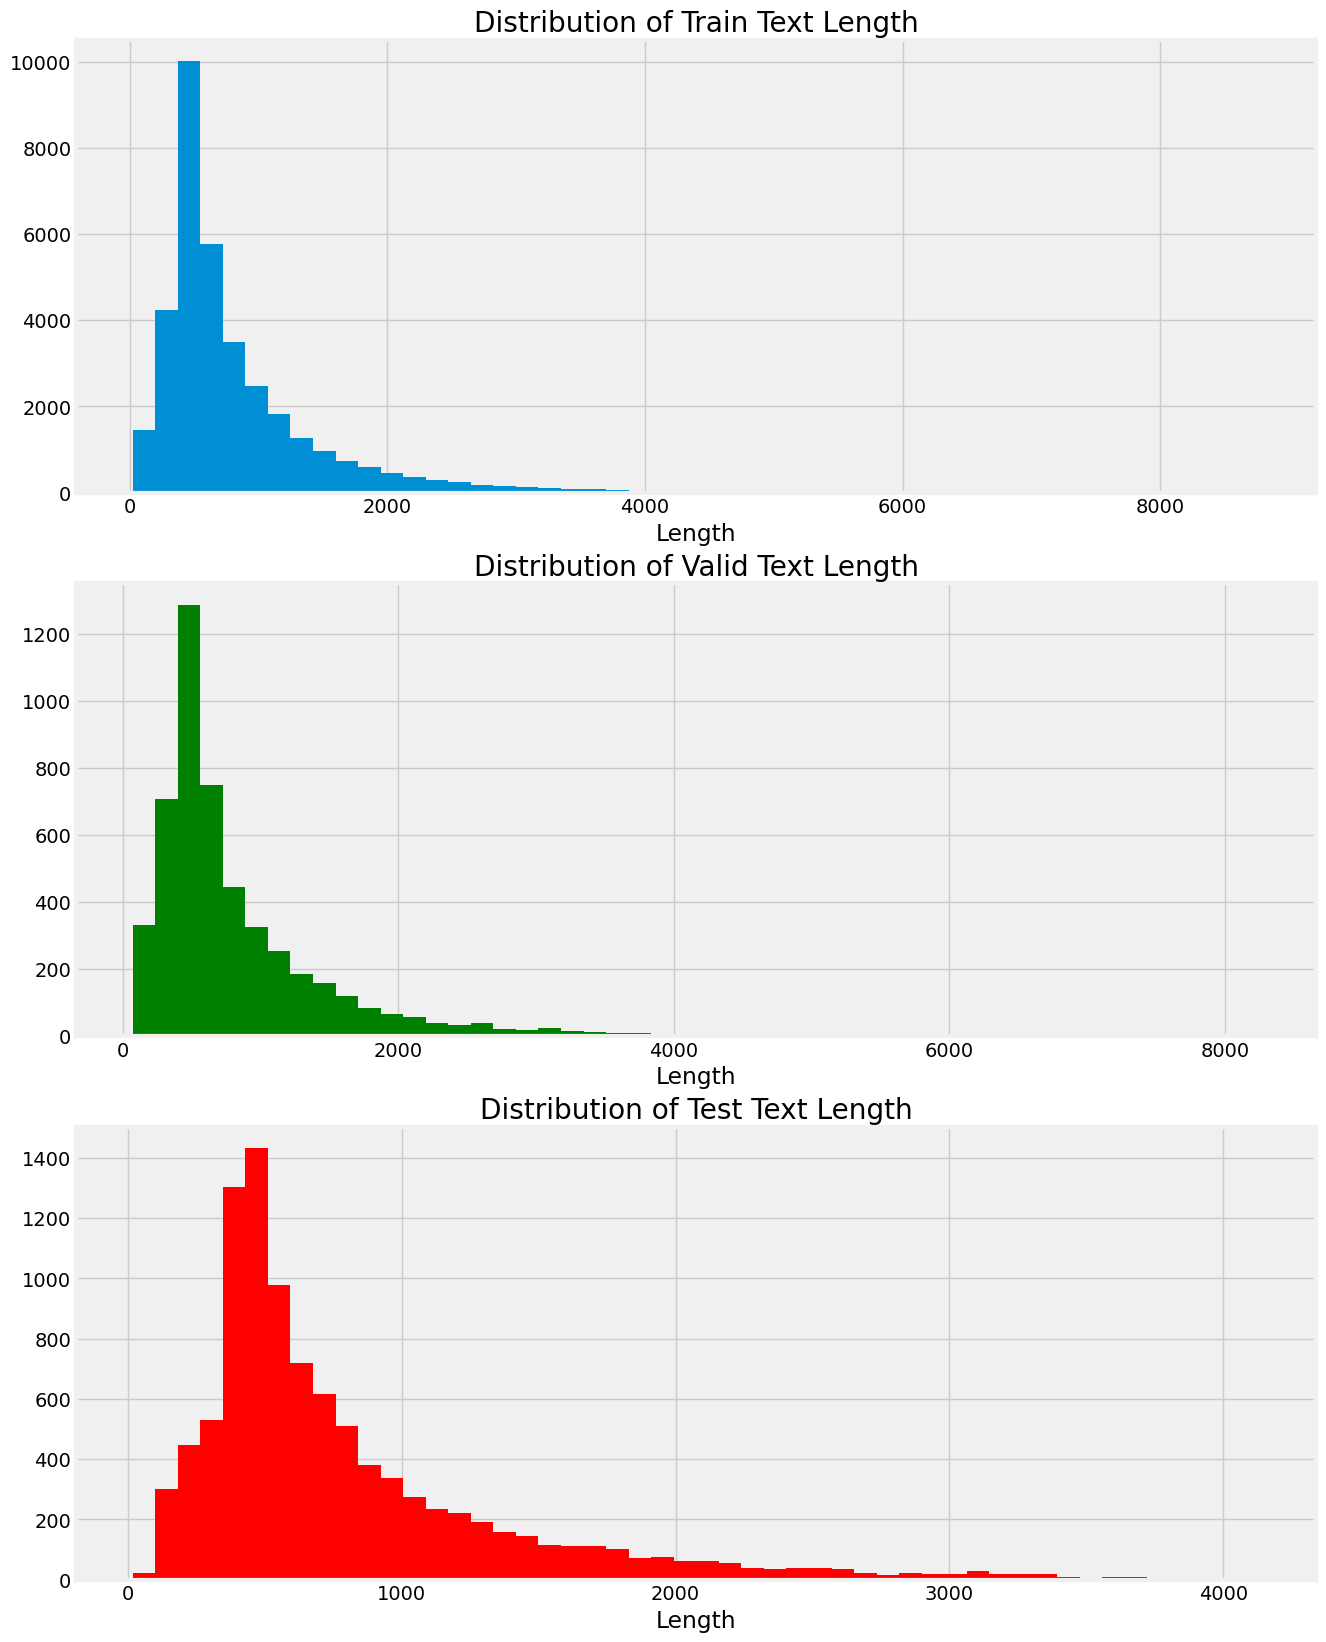

In [ ]:
import matplotlib.pyplot as plt

# Configure the size and style of the plot
plt.figure(figsize=(16, 20))
plt.style.use('fivethirtyeight')

# Initialize the first subplot for visualizing train data
plt.subplot(3, 1, 1)
train_len = [len(l) for l in train_x]
plt.hist(train_len, bins=50)
plt.title('Distribution of Train Text Length')
plt.xlabel('Length')

# Construct the second subplot with the accurate data.
plt.subplot(3, 1, 2)
valid_len = [len(l) for l in valid_x]
plt.hist(valid_len, bins=50, color='green')
plt.title('Distribution of Valid Text Length')
plt.xlabel('Length')

# Construct the test data's third subplot.
plt.subplot(3, 1, 3)
test_len = [len(l) for l in test_x]
plt.hist(test_len, bins=50, color='red')
plt.title('Distribution of Test Text Length')
plt.xlabel('Length')

# Show the plot
plt.show()


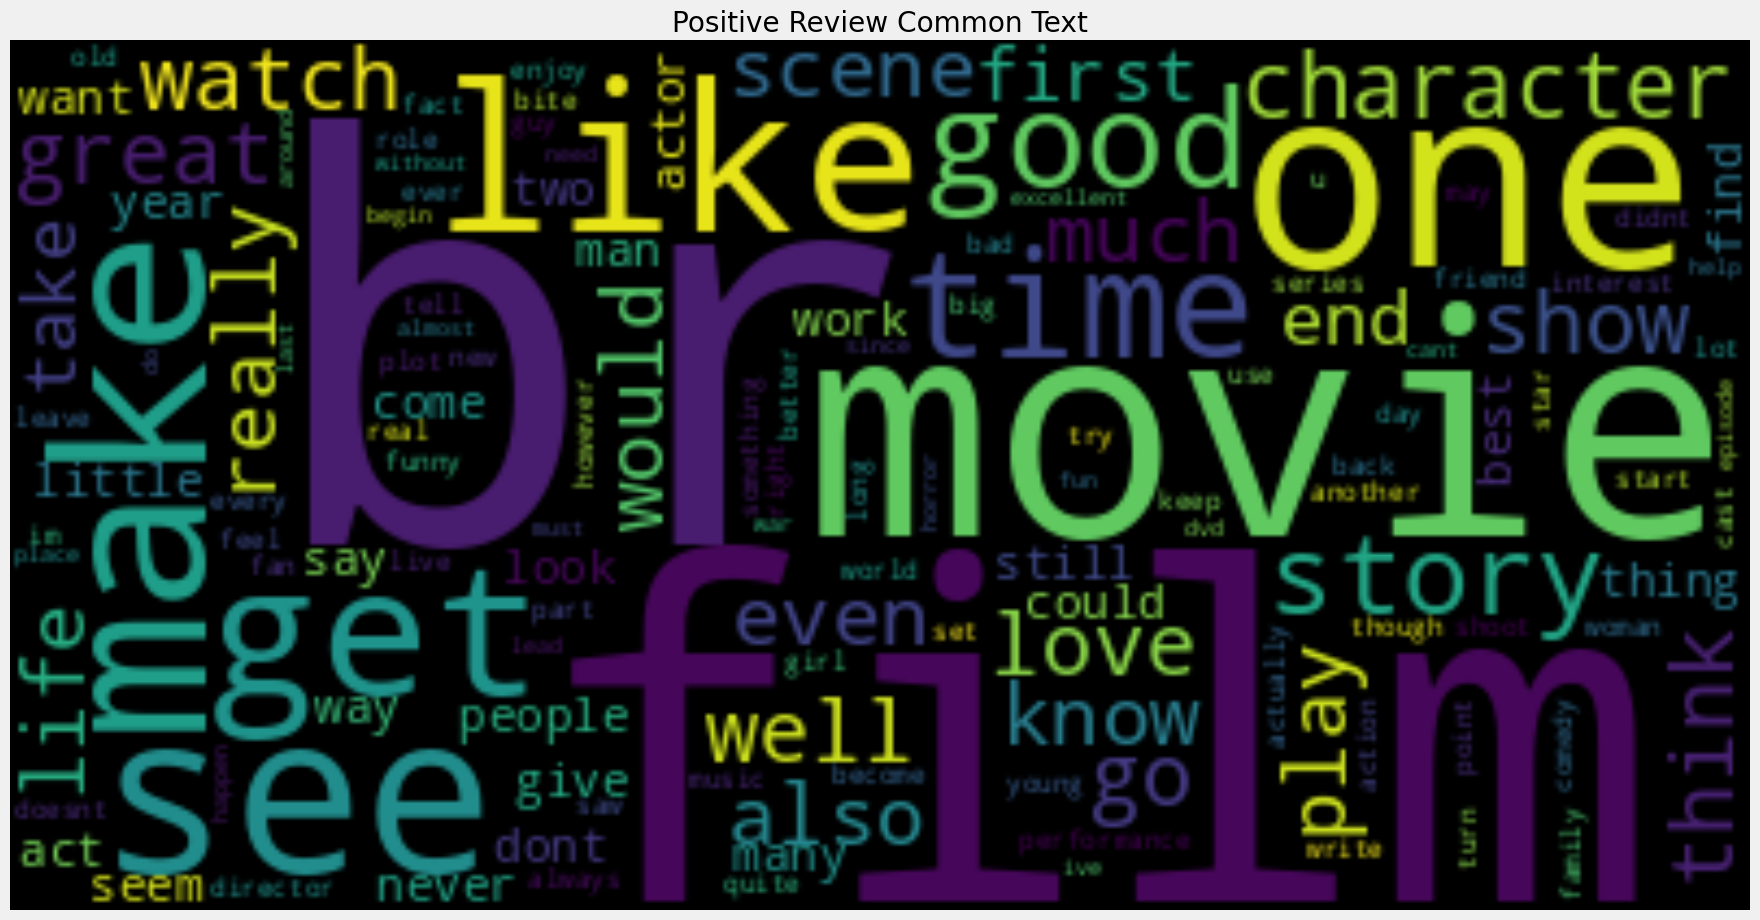

In [ ]:
# Define the size of the figure.
plt.figure(figsize=(20, 20))

# Determine the frequency distribution of words in positive reviews.
pos_freq = FreqDist(' '.join(train[train['sentiment'] == 1].review).split(' '))

# Create a word cloud from the frequency distribution.
wc = WordCloud().generate_from_frequencies(frequencies=pos_freq)

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.title('Positive Review Common Text')
plt.axis('off')
plt.show()

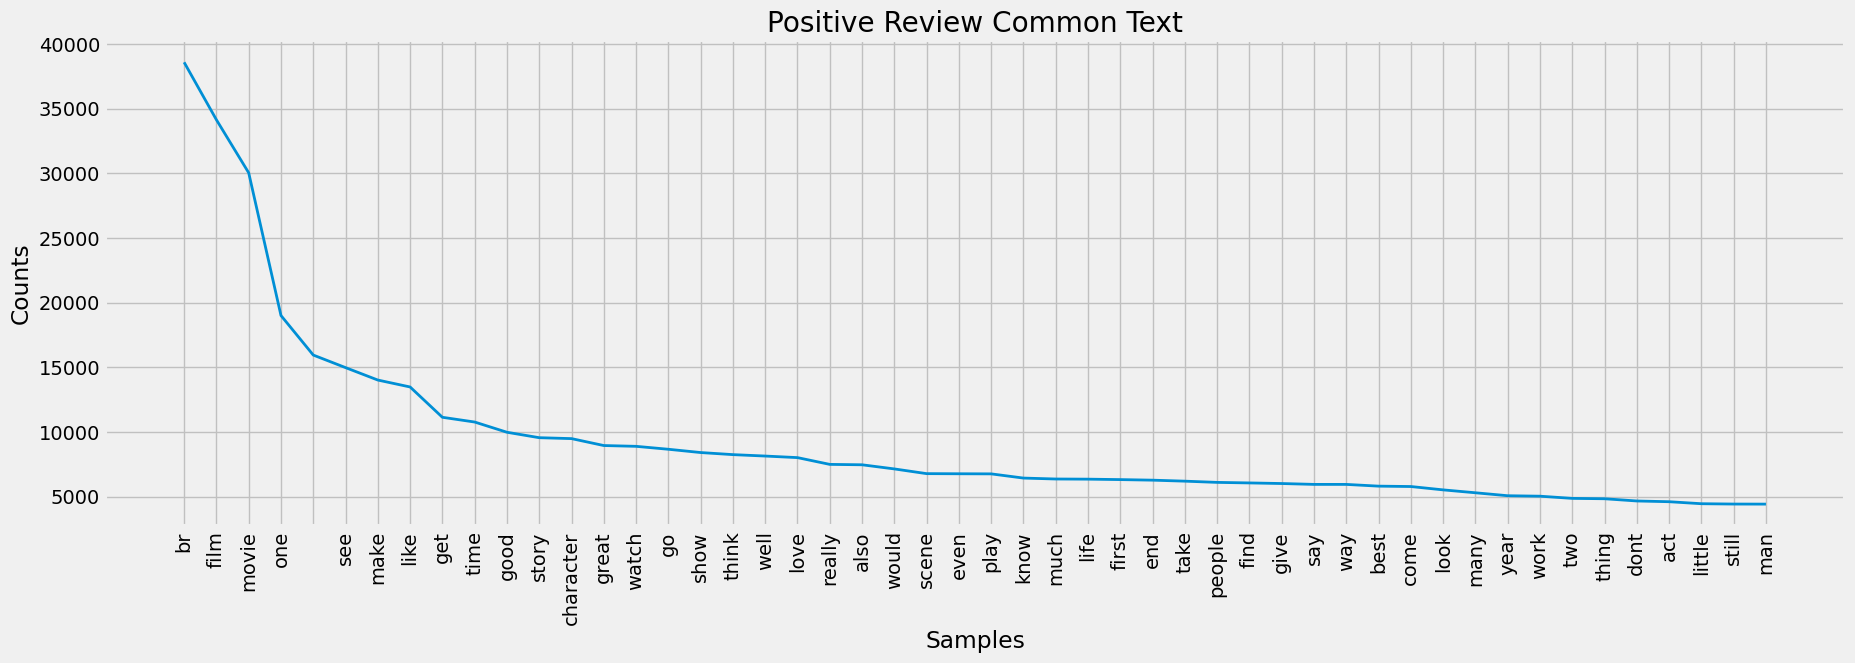

In [ ]:
# Define the size of the figure.
plt.figure(figsize=(20, 6))

# Determine the frequency distribution of words in positive reviews.
pos_freq = FreqDist(' '.join(train[train['sentiment'] == 1].review).split(' '))

# Create a plot of the frequency distribution's top 50 terms.
pos_freq.plot(50, cumulative=False, title='Positive Review Common Text')

# Show the plot
plt.show()

**Building The Model [5]**

In [ ]:

# Importing the required libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the sentences
tokenizer = Tokenizer()

# Preparing vocabulary
tokenizer.fit_on_texts(train_x)

# Convert text to sequences of integers
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)

# Preparing sequences with the same length by using padding
train_x = pad_sequences(train_x, maxlen=120)
valid_x = pad_sequences(valid_x, maxlen=120)
test_x = pad_sequences(test_x, maxlen=120)


In [ ]:
# Determine the vocabulary's size
size_of_vocabulary = len(tokenizer.word_index) + 1

# Print the size of vocabulary
print("The size of vocabulary:", size_of_vocabulary)


The size of vocabulary: 129113


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Initialize the sequential model
model = Sequential()

# Include an embedding layer with an input length of 120, an output dimension of 128, and the vocabulary size as the input dimension.
model.add(Embedding(size_of_vocabulary, 128, input_length=120))

# To avoid overfitting, include a bidirectional LSTM layer with 64 units and a 0.2 dropout.
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)))

# To decrease the dimensionality of the LSTM layer's output, add a global max pooling layer.
model.add(GlobalMaxPooling1D())

# # Include a dense layer with ReLU activation and 32 units.
model.add(Dense(32, activation='relu'))

# Add a dropout layer with a rate of 0.05 to prevent overfitting
model.add(Dropout(0.05))

# Add a dense layer with a single output unit and sigmoid activation to get the probability of the sentiment being positive
model.add(Dense(1, activation='sigmoid'))

# CCompile the model using the binary cross-entropy loss, Adam optimizer, and accuracy as the measure.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define an early terminating callback to avoid overfitting and a model checkpoint to save the best model while training.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Print the summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 128)          16526464  
                                                                 
 bidirectional (Bidirection  (None, 120, 128)          98816     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3



**Training the model [5]**

In [ ]:

# Train the model and save its training history.
history = model.fit(train_x, train_y, batch_size=128, epochs=4,
                    validation_data=(valid_x, valid_y), verbose=1, callbacks=[es, mc])


Epoch 1/4
274/274 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8164
Epoch 1: val_accuracy improved from -inf to 0.88540, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 34s 101ms/step - loss: 0.3908 - accuracy: 0.8164 - val_loss: 0.2803 - val_accuracy: 0.8854
Epoch 2/4
274/274 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9436
Epoch 2: val_accuracy did not improve from 0.88540
274/274 [==============================] - 18s 65ms/step - loss: 0.1580 - accuracy: 0.9436 - val_loss: 0.3139 - val_accuracy: 0.8796
Epoch 3/4
274/274 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9783
Epoch 3: val_accuracy did not improve from 0.88540
274/274 [==============================] - 12s 44ms/step - loss: 0.0669 - accuracy: 0.9783 - val_loss: 0.3984 - val_accuracy: 0.8716
Epoch 4/4
274/274 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9903
Epoch 4: val_accuracy did not improve from 0.88540
274/274 [==============================] - 10s 38ms/step - loss: 0.0310 - accuracy: 0.9903 - val_loss: 0.4819 - val_accuracy: 0.8714
Epoch 4: early stopping


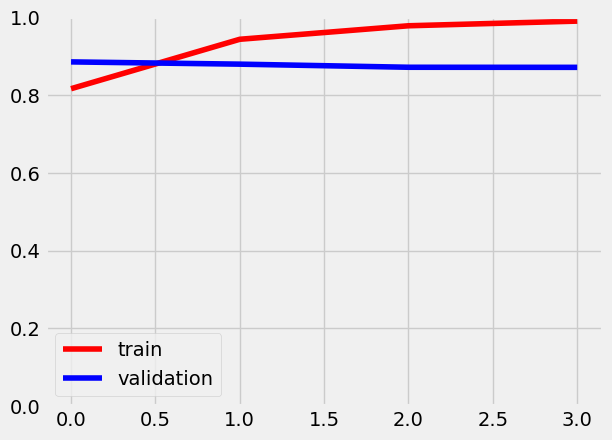

In [ ]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.show()

**Evaluating the model [2.5]**

In [ ]:
#evaluating model
# It loads the saved model called 'best_model.h5'
model = load_model('best_model.h5')

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_x, test_y)

# Prints the accuracy percentage
print('Test Accuracy: {}%'.format(accuracy * 100))


313/313 [==============================] - 3s 6ms/step - loss: 0.2750 - accuracy: 0.8854
Test Accuracy: 88.53999972343445%


**Result and Prediction[2.5]**

In [ ]:
# Predict  sentiment values from test set
ypred = model.predict(test_x)
# Limit the anticipated values to 0 or 1.
ypred[ypred>0.5]=1
ypred[ypred<=0.5]=0
#Compute the Confusion Metrics
print(confusion_matrix(test_y,ypred))

313/313 [==============================] - 3s 7ms/step
[[4304  657]
 [ 489 4550]]


313/313 [==============================] - 2s 5ms/step


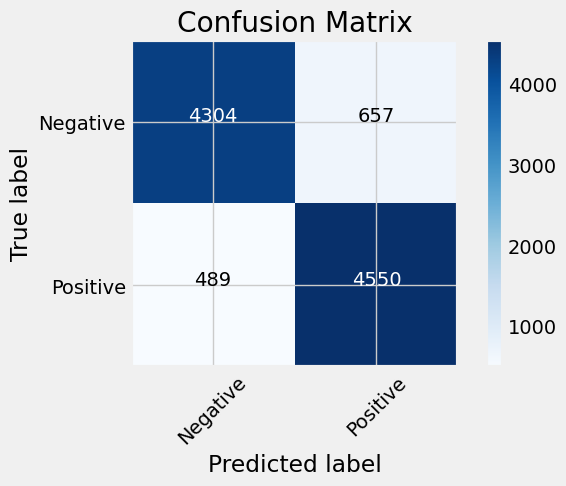

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

#  predictions on the test set
ypred = model.predict(test_x)
ypred[ypred > 0.5] = 1
ypred[ypred <= 0.5] = 0

# Calculation confusion matrix
cm = confusion_matrix(test_y, ypred)

# Define the class labels
classes = ["Negative", "Positive"]

# Creating the heatmap
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Adding the values to the heatmap
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Set the plot parameters
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


313/313 [==============================] - 2s 5ms/step


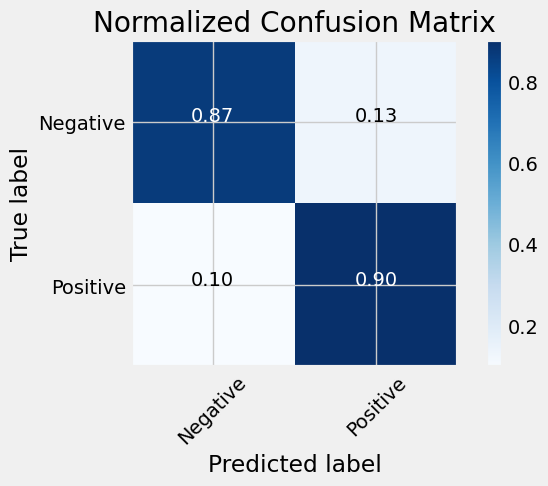

In [ ]:
#  predictions on the test set
ypred = model.predict(test_x)
ypred[ypred > 0.5] = 1
ypred[ypred <= 0.5] = 0

# Calculating the confusion matrix
cm = confusion_matrix(test_y, ypred)

# Define the class labels
classes = ["Negative", "Positive"]

# Creating the normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add the values to the heatmap
thresh = cm_normalized.max() / 2.
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
    plt.text(j, i, format(cm_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

# Set the plot parameters
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
# Print the classification Report
print(classification_report(test_y,ypred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.87      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



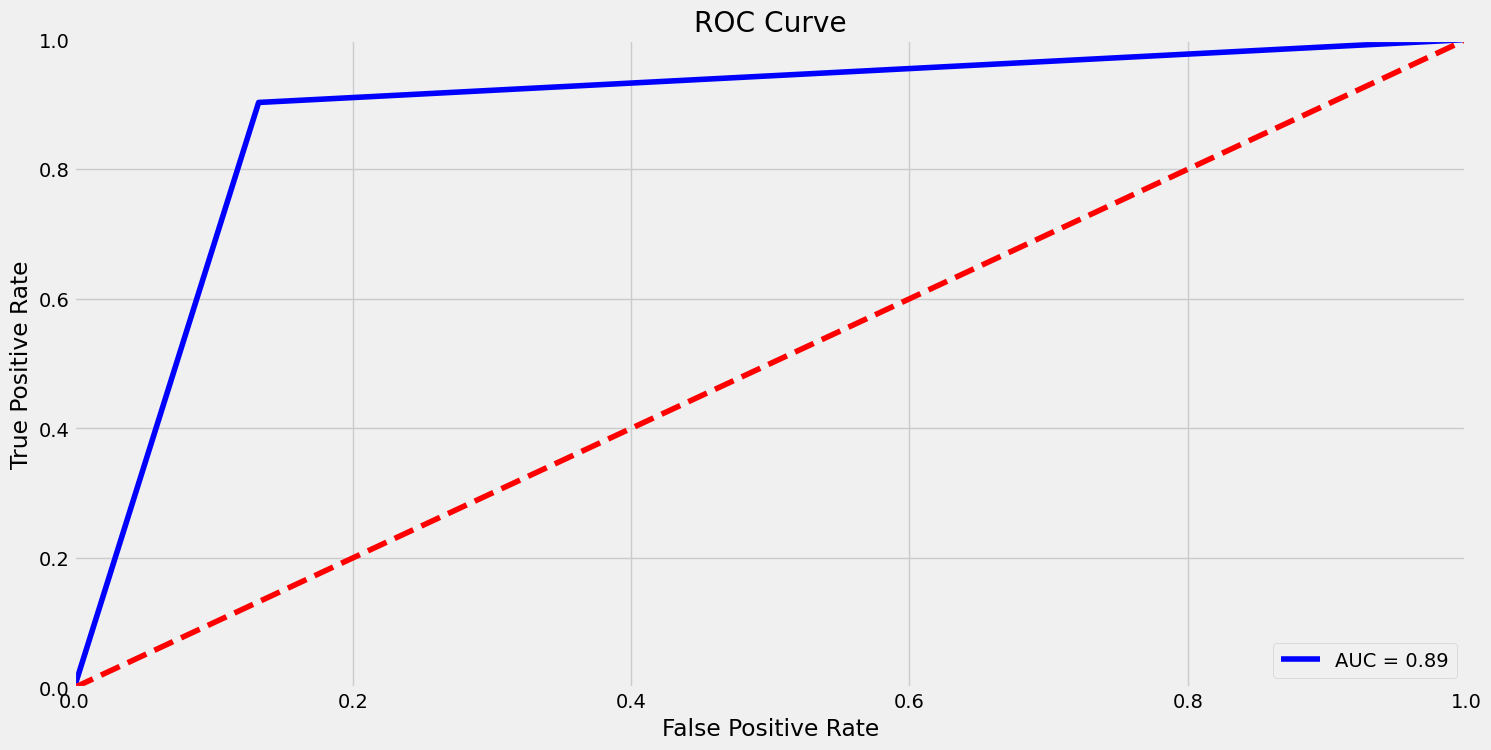

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the test_y and ypred arrays with your true labels and predicted probabilities

# Determine the thresholds, true positive rate, and false positive rate.
fpr, tpr, thresholds = roc_curve(test_y, ypred)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Create a new figure with a size of 16 by 8 inches
plt.figure(figsize=(16,8))

# Plot the ROC curve
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1],'r--')

# Set the x and y limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Set the axis labels
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Add a title
plt.title('ROC Curve')

# Add a legend
plt.legend(loc = 'lower right')

# Display the plot
plt.show()


The model's overall performance is measured by the AUC value. A classifier with a value of 1 is considered ideal, but one with a value of 0.5 is considered random. The model performs better the closer its AUC value is near 1. The aforementioned graph illustrates that the AUC value is 0.89, extremely near to 1.0.

The random classifier, represented by the red dashed line, is below the blue line (ROC curve), suggesting that the model outperforms random guessing.

The trade-off between genuine positive rate (sensitivity) and false positive rate (1 - specificity) is depicted by the ROC curve. The TPR and FPR values fluctuate in proportion to changes in the threshold for categorizing predictions as positive or negative.




The graph indicates that our constructed model performs well. According to the AUC value, the model performs better than a random classifier. The performance of the model is higher the closer the blue line is to the top-left corner (0,1).